# ML в Биологии
## Propensity Score

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression, LinearRegression

from joblib import Parallel, delayed

sns.set(font_scale=1.3, palette='Set2', style='whitegrid')

На основе материалов <a href="https://matheusfacure.github.io/python-causality-handbook/landing-page.html">учебника</a>.

$\newcommand{\indep}{\perp \!\!\! \perp}$
$\newcommand{\notindep}{\not\!\perp \!\!\! \perp}$

## 1. Propensity Score

Рассмотрим [данные](https://github.com/matheusfacure/python-causality-handbook/blob/c817a34e69ef96d2344064f01eeccc129ab365ca/causal-inference-for-the-brave-and-true/data/learning_mindset.csv) об исследовании семинаров о Growth Mindset (установка на рост). Это рандомизированное исследование, проведенное в государственных школах США, целью которого является выявление влияния специальных семинаров Growth Mindset. После прохождения семинаров исследователи наблюдают за студентами во время учебы в колледже. Реальные данные по этому исследованию не являются общедоступными для сохранения конфиденциальности. Будем работать с искусственным набором данных с теми же статистическими свойствами.


Признаки

* `schoolid` &mdash; идентификатор школы учащегося;

* `intervention` &mdash; назначен ли ученику специальный семинар;

* `achievement_score` &mdash; успешность ученика, стандартизированный признак;

* `success_expect` &mdash; самооценка успеха в будущем, показатель предыдущих достижений, измеренный до случайного тритмента;

* `ethnicity` &mdash; этническая принадлежность студента, категориальный признак;

* `gender` &mdash; пол ученика, категориальный признак;

* `frst_in_family` &mdash; первый ли в семье, поступивший в колледж, категориальный признак;

* `school_urbanicity` &mdash; уровень урбанизации школы (сельская, пригородная и т.д.), категориальный признак;

* `school_mindset` &mdash; среднее значение типа мышления учащихся на уровне школы, зафиксированное до эксперимента, стандартизированный признак;

* `school_achievement` &mdash; уровень школьных достижений, измеряемый результатами тестов и подготовкой к колледжу для предыдущих 4 групп учащихся, стандартизированный признак;

* `school_ethnic_minority` &mdash; этнический состав школы, т.е. процент чернокожих, латиноамериканцев или коренных американцев среди учащихся, стандартизированный признак;

* `school_poverty` &mdash; концентрация бедности в школе, т.е. процент учащихся из семей, доходы которых ниже черты бедности, стандартизированный признак;

* `school_size` &mdash; общее количество учащихся во всех четырех классах школы, стандартизированный признак.

In [ ]:
data = pd.read_csv("/content/learning_mindset.csv")
data.sample(5)

Хотя исследование было рандомизированным, не похоже на отсутствие смещения в данных. Дело в том, что возможность принять участие была случайной, но само участие таковым не являлось. Например, мы можем видеть, что студенты с более высокой самооценкой (до начала эксперимента) с большей вероятностью присоединились к семинару.

In [ ]:
data.groupby("success_expect")["intervention"].mean()

Тем не менее посмотрим на разность средних $\mathsf{E}(Y|T=1) - \mathsf{E}(Y|T=0)$, будем рассматривать ее как бейзлайн (базовая оценка, с которой будем сравнивать последующие).

In [ ]:
smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1]

Видим, что у посещающих семинар оценка достижений в среднем на $0,3185 = 0,4723 - 0,1538$ выше общего среднего балла, который равен нулю, поскольку оценка стандартизирована.

In [ ]:
plt.hist(
    data["achievement_score"],
    bins=20, alpha=0.3, label="Вся совокупность"
)
plt.hist(
    data.query("intervention==0")["achievement_score"],
    bins=20, alpha=0.3, color="C2"
)
plt.hist(
    data.query("intervention==1")["achievement_score"],
    bins=20, alpha=0.3, color="C3"
)
plt.vlines(-0.1538, 0, 300, label="Контроль", color="C2")
plt.vlines(-0.1538+0.4723, 0, 300, label="Тест", color="C3")
plt.xlabel("Успешность ученика")
plt.legend(fontsize=12)
plt.show();


### 1.1 Непосредственно Propensity score

Идея: нет необходимости напрямую в модели контролировать все конфаундеры $X$ для достижения условной независимости $(С_1, С_0){\perp\!\!\!\perp} T | X$. Вместо этого достаточно контролировать условное мат. ожидание $\mathsf{E}(T|X)$ как случайную величины. Если тритмент бинарный, то он является условной вероятностью тритмента $\mathsf{P}(T=1|X)$, также называемый **propensity score** $P(x) = \mathsf{P}(T=1|X=x)$.

Propensity score позволяет не ставить условие на весь $X$ для получения независимости. Достаточно поставить условие только на propensity score
$$(C_1, C_0) \perp T | P(X)$$

Propensity score &mdash; это условная вероятность тритмента, по сути это функция, которая преобразует признаки $X$ в тритмент $T$ (вероятность попасть в группу А или в группу В). В ней сосредоточена вся информация о том, как признаки $X$ влияют на распределение участников по группам, $T$. Все остальное &mdash; непрогнозируемый шум. Если мы фиксируем $P(X)$, то сам $X$ ничего не говорит о том, каким может быть $T$.

Посмотрим, как будет выглядеть наш граф.

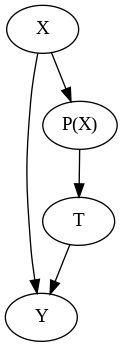

Посещающие семинар и не посещающие изначально несопоставимы, потому что у более амбициозных людей больше вероятность пройти семинар и достичь большего в жизни. Однако, если взять двух студентов из разных групп, но *с одинаковой вероятностью тритмента*, они будут сопоставимы. А **единственная причина**, по которой один из них посещал семинар, а другой нет &mdash; это чистая **случайность**. Фиксация propensity score приводит к тому, что данные выглядят подобно случайным.

---

Покажем, что условие $(C_1, C_0) {\perp\!\!\!\perp} T | P(X)$ эквивалентно $\mathsf{E}(T|P(X), X) = \mathsf{E}(T|P(X))$
Иначе говоря, при рассмотрении $P (X)$ в условии, сам $X$ не дает никакой дополнительной информации о $T$.

Доказательство:
* Левая часть
$$\mathsf{E}(T|P(X), X) = \mathsf{E}(T|X) = P(X)$$

* Правая часть
$$\mathsf{E}(T|P(X)) = \mathsf{E}( \ \mathsf{E}(T|P(X), X) \  |P(X)) = \mathsf{E}( P(X)  |P(X)) = P(X)$$


### 1.2 Propensity Weighting

После получения propensity score можно использовать оценку, которая зависит только от него, а не от всех признаков $X$.

Идея следующая
$$\mathsf{E}(Y|X,T=1)−\mathsf{E}(Y|X,T=0) = \mathsf{E}\bigg[\left.\dfrac{Y}{P(X)}\right|X,T=1\bigg]P(X) - \mathsf{E}\bigg[\left.\dfrac{Y}{1-P(X)}\right|X,T=0\bigg](1-P(X))$$


Первое слагаемое берет всех тех, кто в тестовой группе, и масштабирует их по обратной вероятности попасть в тестовую группу. Тем самым люди с очень низкой вероятностью тритмента имеют высокий вес. Смысл в том, что если у кого-то низкая вероятность тритмента, то этот человек выглядит как представитель контрольной группы. Однако этот человек был в тестовой группе. Тем самым логично придать ему высокий вес. Это создает популяцию того же размера, что и исходная совокупность данных, но в которой тритмент оказывает влияние на всех.

Аналогично второе слагаемое взаимодействует с контрольной группой, придавая высокий вес тем, которые выглядят так, как будто они в тестовой группе.


Воспользовавшись теоремой Байеса и тем, что propensity score является функцией от $X$ при фиксированном значении $T$, получим:

$$\mathsf{E}\bigg[Y \dfrac{T-P(X)}{P(X)(1-P(X))}\bigg|X\bigg]$$

Далее, интегрируя мат. ожидание по $X$, получаем

$$\mathsf{E}\bigg[Y \dfrac{T-P(X)}{P(X)(1-P(X))}\bigg]$$

Обратите внимание, что $P(X)$ и $1-P(X)$ должны быть больше нуля. Это означает, что у каждого должен быть хотя бы какой-то шанс получить тритмент или не получить его. Иначе говоря, распределения должны пересекаться. Иначе они будут очень разными, не получится надежно экстраполировать эффект одной группы на другую.

## 2. Propensity Score Estimation


В идеальном мире у нас был бы истинный $P(x)$. Но в реальности мы можем получить только его оценку $\widehat{P}(x)$. Наиболее распространенный способ &mdash; логистическая регрессия.

Подготовим данные для последующего обучения моделей

In [ ]:
# список категориальных переменных
categ = ["ethnicity", "gender", "school_urbanicity"]
# список вещественных переменных
cont = [
    "school_mindset", "school_achievement",
    "school_ethnic_minority", "school_poverty", "school_size"
]

data_with_categ = pd.concat([
    # вещественные признаки
    data.drop(columns=categ),
    # преобразование категориальных признаков
    pd.get_dummies(data[categ], columns=categ, drop_first=False)
], axis=1)

print(data_with_categ.shape)

Напишем функцию, позволяющую оценивать propensity score $\mathsf{P}(T=1|X=x)$ с помощью лог регрессии и рассчитывать веса $\dfrac{T-P(X)}{P(X)(1-P(X))}$ для ATE из формулы выше.

In [ ]:
def calculate_ps(df, X, T):
    '''
    Обучает логистическую регрессию для оценки propensity_score

    Аргументы:
    df : pd.DataFrame
        данные
    X : pd.DataFrame.columns
        список признаков-конфаундеров для расчета propensity score
    T : str
        признак-тритмент (группа)

    Возвращает:
    ps --  propensity score
    weight -- веса для объектов в группах теста и контроля
    '''

    # 1. Определим признаки и тритмент
    X_data = df[X]
    T_data = df[T]

    # 2. Обучим логистическую регрессию для оценки propensity score
    model = LogisticRegression(solver='liblinear')
    model.fit(X_data, T_data)

    # 3. Рассчитаем propensity score для каждого наблюдения
    ps = model.predict_proba(X_data)[:, 1]

    # 4. Рассчитаем веса
    weight = (T_data - ps) / (ps * (1 - ps))

    return ps, weight

Рассчитаем propensity score, для этого выделим конфаундеры и воспользуемся `calculate_ps`

In [ ]:
X = cont + list(data_with_categ.columns[data_with_categ.columns.str.startswith("ethnicity")])
T = "intervention"

ps, weight = calculate_ps(data_with_categ, X, T)

# Выводим первые 5 значений propensity score и весов
print("Первые 5 значений propensity score:", ps[:5])
print("Первые 5 значений весов:", weight[:5])

Убедимся, что propensity score действительно воссоздает популяцию, в которой на всех оказывается влияние, и наоборот.

In [ ]:
# Суммируем веса для тестовой группы и контрольной группы
test_weight_sum = weight[data_with_categ[T] == 1].sum()
control_weight_sum = weight[data_with_categ[T] == 0].sum()

print("Размер исходной выборки:", data_with_categ.shape[0])
print("Размер раздутой тестовой выборки:", test_weight_sum)
print("Размер раздутой контрольной выборки:", control_weight_sum)


Можно также использовать propensity score, чтобы увидеть смещение.

Если сегментация учеников по уровню самооценки имеет разный propensity score, это означает, что тритмент не является рандомным. Если эта же величина влияет и на таргет, получаем случай [парадокса Симпсона](https://ru.wikipedia.org/wiki/Парадокс_Симпсона)


Постройте boxplot, демонстрирующий распределение propensity score в зависимости от самооценки студента `success_expect`.

In [ ]:
data_with_categ['propensity_score'] = ps

plt.figure(figsize=(10, 6))
sns.boxplot(x='success_expect', y='propensity_score', data=data_with_categ)
plt.title('Распределение Propensity Score в зависимости от самооценки студента')
plt.xlabel('Самооценка студента (success_expect)')
plt.ylabel('Propensity Score')
plt.xticks(rotation=45)
plt.show()

Также необходимо проверить, есть ли пересечение между тестом и контролем. Для этого можно построить гистограмму propensity score по двум группам (`hue` = $T$ при использовании методов библиотеки `seaborn`).

In [ ]:
data_with_categ['propensity_score'] = ps

plt.figure(figsize=(10, 6))
sns.histplot(data=data_with_categ, x='propensity_score', hue='intervention', kde=True, bins=30, palette='muted', stat='density')
plt.title('Распределение Propensity Score для тестовой и контрольной групп')
plt.xlabel('Propensity Score')
plt.ylabel('Плотность')
plt.show()

Что вы можете сказать о распределениях propensity score? Почему нужно пересечение гистограмм весов для тестовой и контрольной выборок?


**Ответ:**

Гистограммы propensity score для тестовой и контрольной группы пересекаются, что означает, что в обеих группах есть схожие наблюдения по характеристикам. Это важно, потому что позволяет применить методы выравнивания (например, matching или weighting), минимизируя смещение и обеспечивая корректность оценки эффекта вмешательства. Без пересечения не будет возможности провести корректный анализ, так как для некоторых значений не будет соответствующих наблюдений в другой группе.

Наконец, можем использовать веса из propensity score для оценки среднего эффекта тритмента (можете использовать реализацию `calculate_ps`, написанную ранее)

In [ ]:
def calculate_ate(df, X, T, y):
    '''
    Считает средний причинно-следственный эффект

    Аргументы:
    df : pd.DataFrame
        данные
    X : list
        список признаков для расчета propensity score
    T : str
        признак-тритмент
    y : str
        признак-таргет

    Возвращает:
    ate -- величину среднего эффекта тритмента
    '''

    # 1. Рассчитываем propensity score и веса
    ps, weight = calculate_ps(df, X, T)

    # 2. Разделяем данные на тестовую и контрольную группу
    treated = df[df[T] == 1]
    control = df[df[T] == 0]

    # 3. Среднее для тестовой группы (с использованием весов)
    mean_treated = (treated[y] * weight[treated.index]).sum() / weight[treated.index].sum()

    # 4. Среднее для контрольной группы (с использованием весов)
    mean_control = (control[y] * weight[control.index]).sum() / weight[control.index].sum()

    # 5. Средний эффект тритмента
    ate = mean_treated - mean_control

    return ate, mean_treated, mean_control

In [ ]:
ate, mean_treated, mean_control = calculate_ate(data_with_categ, X, T, 'achievement_score')

print(f"mean С1 = {mean_treated}")
print(f"mean С0 = {mean_control}")
print(f"ATE = {ate}")

**Выводы:**

Средний эффект тритмента (ATE) составил 0.457. Это означает, что вмешательство (intervention) увеличивает таргетный показатель (achievement_score) на 0.457 по сравнению с контрольной группой. Среднее значение для тестовой группы (С1) равно 0.307, а для контрольной группы (С0) — -0.151.

При попытке оценить стат. значимость оценки ATE и построить для нее доверительный интервал возникнет следующая проблема. Обычные оценки ковариационной матрицы справедливы только если имеется истинная $P(x)$. Но мы используем оценку, которая вносит свое смещение. Простой способ исправить это &mdash; использование бутстрепа

In [ ]:
np.random.seed(88)
bootstrap_sample = 10_000

In [ ]:
%%time

# Запускаем параллельно функцию calculate_ate с указанными далее аргументами имитируя цикл
ates = Parallel(n_jobs=4)(
    delayed(calculate_ate)(data_with_categ.sample(frac=1, replace=True), X, T, "achievement_score")
    for _ in range(bootstrap_sample)
)
ates = np.array(ates)

Посмотрим на результаты

In [ ]:
print(f"ATE = {ates.mean():.3f}")
print(f"95% C.I. = ({np.percentile(ates, 2.5):.3f}, {np.percentile(ates, 97.5):.3f})")

Также можем посмотреть на бутстрепное распределение ATE

In [ ]:
sns.kdeplot(ates, lw=3)
plt.vlines(np.percentile(ates, [2.5, 97.5]), 0, 25,
           color='red', lw=3, linestyles="dotted", label="95% CI")
plt.title("Бутстрепное распределение ATE")
plt.legend()
plt.show();


**Вывод**

1. Пик распределения ATE указывает на выраженный эффект тритмента, что подтверждается узким доверительным интервалом.

2. 95% доверительный интервал (красные линии) четко указывает на область, где с вероятностью 95% находится истинное значение ATE.

3. Сужение интервала подтверждает высокую статистическую значимость эффекта, но требует проверки на стабильность.

# Справочный дополнительный материал

## 4. Особенности работы с Propensity Score

Может возникнуть желание использовать все возможные инструменты машинного обучения, чтобы сделать оценку propensity score максимально точной. Но не стоит все это делать вслепую. Теория о propensity score появилась недавно, и в ней еще многое не изучено.

Однако, можно сказать следующее. Прогнозное качество propensity score не отражается на его уравновешивающих свойствах. **По сравнению с традиционным машинным обучением в причинно-следственном выводе необходимо отказаться от рассмотрения любых задач как задач прогнозирования**. Фактически, минимизация ошибки propensity score может даже навредить цели причинно-следственного вывода. **Propensity score не обязательно должен очень хорошо предсказывать тритмент. Ему просто нужно учесть все конфаундеры.** Если мы будем использовать признаки, которые очень классные для прогнозирования тритмента, но не имеют никакого отношения к результату, это увеличит дисперсию propensity score.

---

Для примера рассмотрим две школы. Одна в 99% случаев назначает тритмент (i.e. включает ученика в тестовую группу нового подхода к обучению), а другая только в 1% случаев. Причем делают это рандомизировано, поэтому нет необходимости что-либо контролировать дополнительно.

Если добавить признак `school` в модель оценки propensity score, она будет обладать очень высокой прогнозной способностью. Однако в итоге получим выборку, в которой все в школе А проходят семинар, что приводит к огромной дисперсии.

*Отметим, что в этом примере истинный эффект равен 0.1*

In [ ]:
np.random.seed(42)
school_a = pd.DataFrame(dict(T=np.random.binomial(1, 0.99, 400), school=0, intercept=1))
school_b = pd.DataFrame(dict(T=np.random.binomial(1, 0.01, 400), school=1, intercept=1))

ex_data = pd.concat([school_a, school_b])
ex_data['y'] = np.random.normal(1 +  0.1*ex_data["T"])
ex_data.head()

Проведем бутстреп по двум моделям. Первая использует `school` как признак, вторая обучает константу.

In [ ]:
%%time

ate_w_f =  Parallel(n_jobs=4) (
    delayed(run_ps) (ex_data.sample(frac=1, replace=True), ["school"], "T", "y")
    for _ in range(bootstrap_sample)
)
ate_w_f = np.array(ate_w_f)


ate_wo_f =  Parallel(n_jobs=4) (
    delayed(run_ps) (ex_data.sample(frac=1, replace=True), ["intercept"], "T", "y")
    for _ in range(bootstrap_sample)
)
ate_wo_f = np.array(ate_wo_f)

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.histplot(ate_w_f, label="C доп. признаком")
sns.histplot(ate_wo_f, label="Без доп. признака")
plt.legend()
plt.subplot(122)
sns.kdeplot(ate_w_f, lw=3, common_norm=False, label="C доп. признаком")
sns.kdeplot(ate_wo_f, lw=3, common_norm=False, label="Без доп. признака")
plt.legend()
plt.suptitle("Сравнение двух моделей оценки propensity score")
plt.show();

По графику видим, что
* оценка propensity score без признака `school` несмещенная и обладает небольшой дисперсией,
* оценка propensity score с признаком `school` смещенная и обладает большой дисперсией.

---

Нередко, когда данные сильно не сбалансированы, можно наблюдать следующую ситуацию. Для большого количества объектов здесь вообще нет сопоставимых. В таком случае можно обрезать выборку на основне propensity score. Эмпирическое правило &mdash; удалять тех, у кого вес не меньше 20.

In [ ]:
ps_test = np.random.beta(4, 1, 500)
ps_control = np.random.beta(1, 3, 500)

plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.histplot(ps_test, label="Тест")
sns.histplot(ps_control, label="Контроль")
plt.subplot(122)
sns.kdeplot(ps_test, lw=3, common_norm=False, label="Тест")
sns.kdeplot(ps_control, lw=3, common_norm=False, label="Контроль")
plt.suptitle("Проверка на сопоставимость")
plt.show();

### Propensity Score Matching

Можно также использовать propensity score как признак для линейной регрессии. Тем самым будет производится мэтчинг по propensity score

In [ ]:
smf.ols(
    "achievement_score ~ intervention + propensity_score", data=data_ps
).fit().summary().tables[1]